In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from curvemetrics.datafetcher import DataFetcher
from curvemetrics.metricsprocessor import MetricsProcessor
import timeit
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
from web3 import Web3
import matplotlib.pyplot as plt
from curvemetrics.datahandler import DataHandler
import json
from curvemetrics.queries import queries
import ccxt
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os

In [4]:
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata)

In [62]:
pool = "0xceaf7747579696a2f0bb206a14210e3c9e6fb269" # UST pool
start = datetime.timestamp(datetime(2022, 5, 1))
end = datetime.timestamp(datetime(2022, 5, 20))

swaps_data = datahandler.get_swaps_data(pool, start, end)

ignore = set(['0x6c3f90f043a72fa612cbac8115ee7e52bde6e490']) # metapool, ignore LP token for now
tokens = set(swaps_data['tokenBought']) - ignore
ohlcvs = {}
for token in tokens:
    ohlcvs[token] = datahandler.get_ohlcv_data(token, start, end)

{'0xdac17f958d2ee523a2206206994597c13d831ec7', '0x6b175474e89094c44da98b954eedeac495271d0f', '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', '0xa693b19d2931d498c5b318df961919bb4aee87a5'}
0xdac17f958d2ee523a2206206994597c13d831ec7
0x6b175474e89094c44da98b954eedeac495271d0f
0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48
0xa693b19d2931d498c5b318df961919bb4aee87a5


In [ ]:
window = timedelta(days=1)
markout_col = f'{int(window.total_seconds())}.Markout'
df = swaps_data.copy()
df = df[(df['tokenBought'] != ignore[0]) & (df['tokenSold'] != ignore[0])]
df = MetricsProcessor.markout(df, ohlcvs, window=window)
df.head()

{'0xdac17f958d2ee523a2206206994597c13d831ec7', '0xa693b19d2931d498c5b318df961919bb4aee87a5', '0x6b175474e89094c44da98b954eedeac495271d0f', '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'}


/root/curve-lp-metrics/curvemetrics/metricsprocessor.py:363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['markoutBoughtPrice'] = df.apply(lambda x: ohlcvs[x['tokenBought']].loc[x['roundedDate'] + window]['close'], axis=1)
/root/curve-lp-metrics/curvemetrics/metricsprocessor.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['currentSoldPrice'] = df.apply(lambda x: ohlcvs[x['tokenSold']].loc[x['roundedDate']]['close'], axis=1)
/root/curve-lp-metrics/curvemetrics/metricsprocessor.py:365: SettingWit

,id,timestamp,tx,pool_id,amountBought,amountSold,tokenBought,tokenSold,buyer,gasLimit,gasUsed,isUnderlying,block_gte,block_lt,block,86400.Markout
roundedDate,,,,,,,,,,,,,,,,
2022-05-01 00:09:00,0x362aa877181b062994abbb27797fc8886f01c55392b8...,1651363761,0x362aa877181b062994abbb27797fc8886f01c55392b8...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,2.458353e+05,2.458782e+05,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xa693b19d2931d498c5b318df961919bb4aee87a5,0xc88e39dd0c031004228c3cb86a7981da69672170,362281,248006,1,14688668,14688678,14688673,-18.350705
2022-05-01 00:26:00,0xff62015ff7169854b33215adce68a284bb9460cd5248...,1651364785,0xff62015ff7169854b33215adce68a284bb9460cd5248...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,1.006291e+06,1.006476e+06,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xa693b19d2931d498c5b318df961919bb4aee87a5,0xdef171fe48cf0115b1d80b88dc8eab59176fee57,770138,468034,1,14688738,14688748,14688741,-1192.147007
2022-05-01 00:31:00,0xdd78807a9bd8a4d692c10cb56606abd6dca5fe902870...,1651365059,0xdd78807a9bd8a4d692c10cb56606abd6dca5fe902870...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,1.521892e+06,1.522206e+06,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xa693b19d2931d498c5b318df961919bb4aee87a5,0x075f289548e01fbfcfbbf4ee73f80de6267eea7c,383155,265130,1,14688758,14688768,14688760,-314.184791
2022-05-01 00:45:00,0x7948dcd4ec132f57785f322a1ed43bd206736d074009...,1651365892,0x7948dcd4ec132f57785f322a1ed43bd206736d074009...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,2.697644e+04,2.700000e+04,0xa693b19d2931d498c5b318df961919bb4aee87a5,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc1bd21ecd832ef3c3b1a393a0d66dd2b92c0a944,430404,308688,1,14688818,14688828,14688824,3.417135
2022-05-01 00:46:00,0xb39cc0605bed1e240760d64fece4b872cbb4c4224097...,1651365936,0xb39cc0605bed1e240760d64fece4b872cbb4c4224097...,0xceaf7747579696a2f0bb206a14210e3c9e6fb269,2.898249e+03,2.898880e+03,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xa693b19d2931d498c5b318df961919bb4aee87a5,0x16ddd44da2f56e9b52bf447e25fff8f328e3c443,383098,265082,1,14688818,14688828,14688826,-3.530412


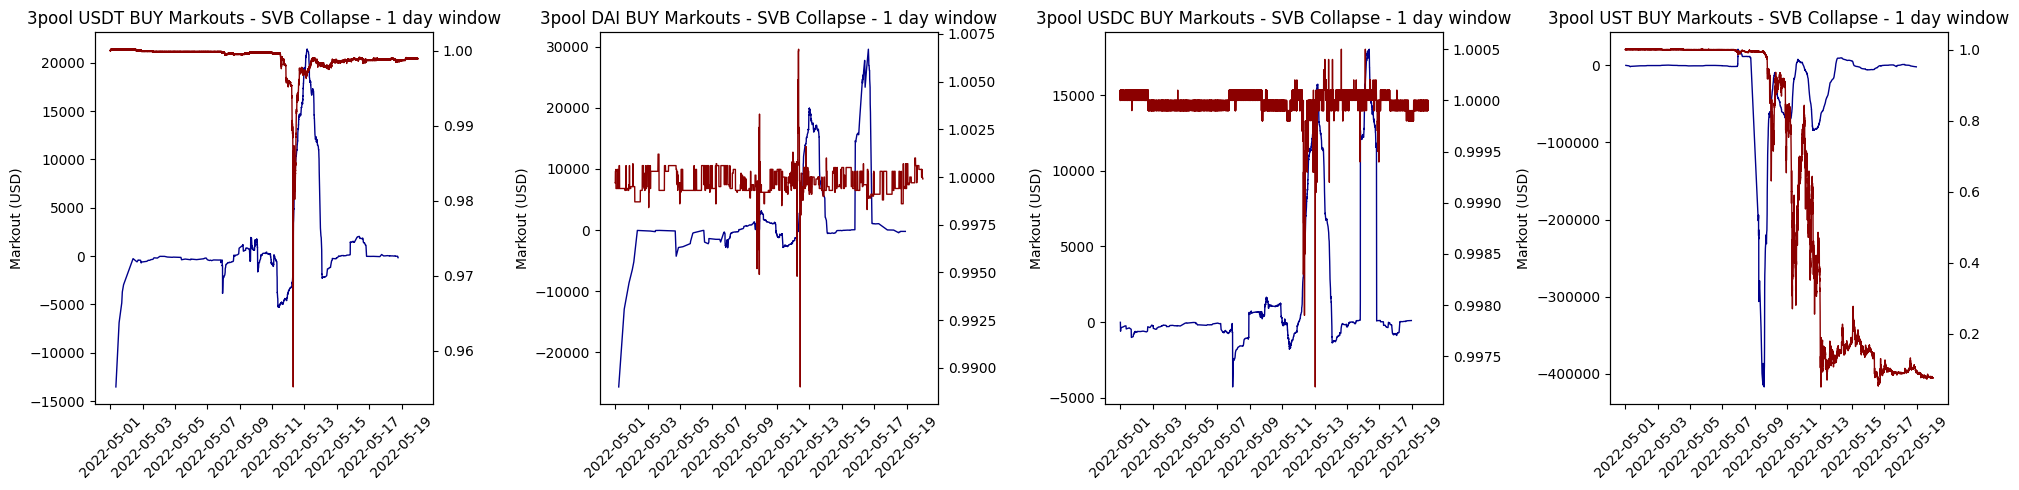

In [65]:
f, axs = plt.subplots(1, len(tokens), figsize=(20, 5))
for i, token in enumerate(tokens):
    symbol = token_metadata[token]['symbol']
    ndf = df[df['tokenBought'] == token]
    rolling_markouts = ndf[markout_col].rolling(window).mean()
    ax2 = axs[i].twinx()
    axs[i].plot(rolling_markouts.index, rolling_markouts, c='darkblue', linewidth=1)
    ax2.plot(ohlcvs[token].index, ohlcvs[token]['close'], c='darkred', linewidth=1)
    axs[i].set_title(f'3pool {symbol} BUY Markouts - UST Collapse - {window.days} day window')
    axs[i].tick_params(axis="x", rotation=45)
    axs[i].set_ylabel('Markout (USD)')

f.tight_layout()
f.show()

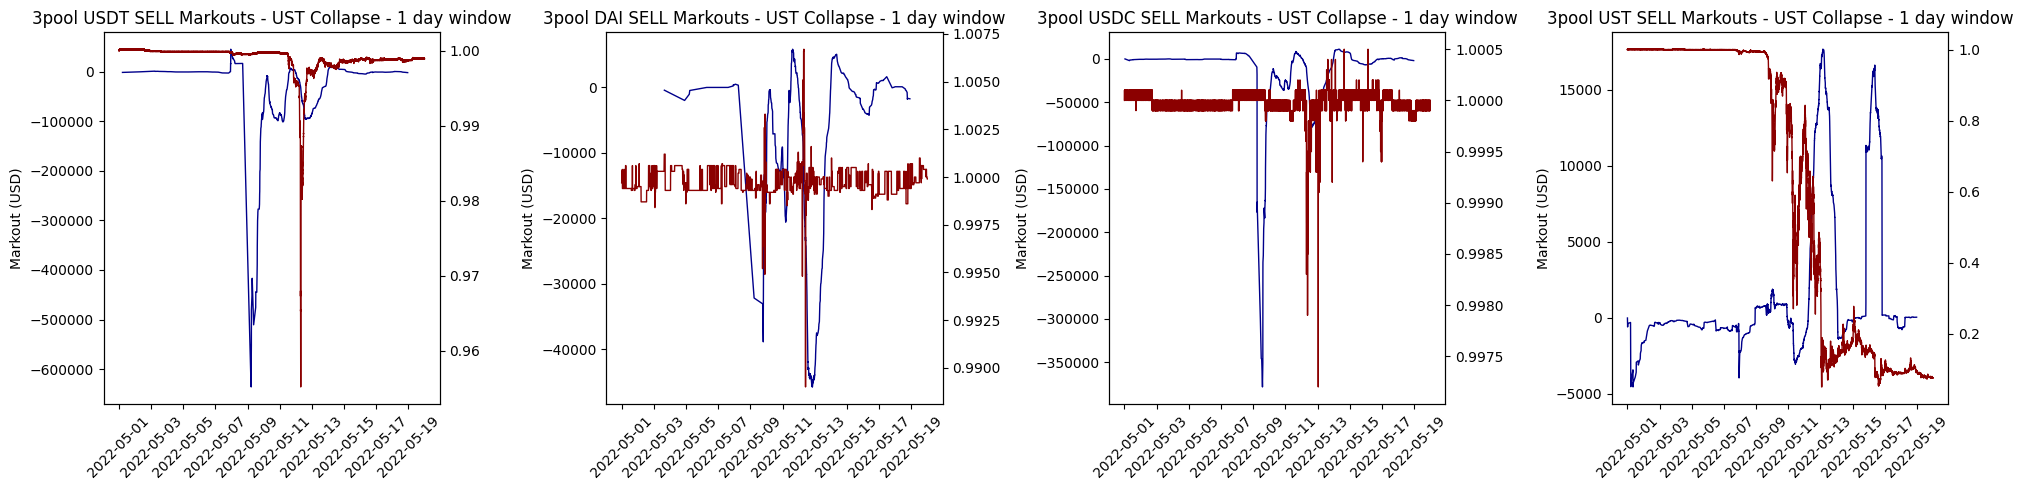

In [78]:
f, axs = plt.subplots(1, len(tokens), figsize=(20, 5))
for i, token in enumerate(tokens):
    symbol = token_metadata[token]['symbol']
    ndf = df[df['tokenSold'] == token]
    rolling_markouts = ndf[markout_col].rolling(window).mean()
    ax2 = axs[i].twinx()
    axs[i].plot(rolling_markouts.index, rolling_markouts, c='darkblue', linewidth=1)
    ax2.plot(ohlcvs[token].index, ohlcvs[token]['close'], c='darkred', linewidth=1)
    axs[i].set_title(f'3pool {symbol} SELL Markouts - UST Collapse - {window.days} day window')
    axs[i].tick_params(axis="x", rotation=45)
    axs[i].set_ylabel('Markout (USD)')

f.tight_layout()
f.show()

# Let's look at high-performing traders

In [89]:
top_100_swaps = df.sort_values(markout_col, ascending=False).head(100)

In [93]:
len(set(top_100_swaps['buyer']))

30

In [115]:
ranking = df.groupby(by='buyer').agg({
    markout_col: ['sum', 'mean', 'count'],
})
ranking.head()

86400.Markout                     
                                                     sum           mean count
buyer                                                                        
0x0000000000007f150bd6f54c40a34d7c3d5e9f56 -8.865612e+05   -6114.215034   145
0x00000000c2cf7648c169b25ef1c217864bfa38cc -1.169850e+05   -1244.521154    94
0x000f7f22bfc28d940d4b68e13213ab17cf107790 -5.143586e+06 -125453.314574    41
0x004ac56cbb6dfece386d2a03de89af4ef160eeb5  1.478126e+01      14.781259     1
0x004e5752600518d32a8081786410964ca3ee1add -3.208547e+04   -6417.093873     5

In [116]:
ranking_by_sum = ranking.sort_values((markout_col, 'sum'), ascending=False)
ranking_by_sum.head()

86400.Markout                     
                                                     sum           mean count
buyer                                                                        
0xdb886bf718fbf354eb4202b03ad13b1cafb01276  4.003084e+06   75529.895340    53
0xc4da602cae17e6afc33296fd17938fb3bbcd0230  1.804046e+06  100224.754383    18
0x91351c5fb0af77c0a9903ba16445da6206eb641f  9.908421e+05  141548.877296     7
0xa7888f85bd76deef3bd03d4dbcf57765a49883b3  9.059975e+05  113249.689124     8
0x6f3d8a2be95fa3bd694a51ba32100f4e599fdde5  7.763829e+05   38819.145276    20

In [148]:
ranking_by_sum.tail()

86400.Markout                     
                                                     sum           mean count
buyer                                                                        
0x59964a45f2efbb001859ab57e3e4cdcfb7f3d2c0 -1.030508e+07 -936825.845566    11
0x3cf4d7e888425a37c8bbfce75b5741fc84cfabc8 -1.076459e+07 -151613.971028    71
0x66b870ddf78c975af5cd8edc6de25eca81791de1 -1.550278e+07  -35969.334775   431
0x2057cfb9fd11837d61b294d514c5bd03e5e7189a -2.114339e+07  -25753.214888   821
0x220bda5c8994804ac96ebe4df184d25e5c2196d4 -1.920725e+08  -21083.700579  9110

In [149]:
ranking_by_mean = ranking.sort_values((markout_col, 'mean'), ascending=False)
ranking_by_mean.tail()

86400.Markout                     
                                                     sum           mean count
buyer                                                                        
0xf96da4775776ea43c42795b116c7a6eccd6e71b5 -5.947703e+05 -297385.131411     2
0x8889ff5b6323e71c28c26d2c34b8bb52654f00a6 -4.063897e+05 -406389.662056     1
0x459855f0d5ae2196e9c0dc23678ef1ba8cf046bd -5.599878e+05 -559987.810130     1
0xdacab5a8b960f78e6730e8e87f3cd87c6fef0921 -1.664963e+06 -832481.717719     2
0x59964a45f2efbb001859ab57e3e4cdcfb7f3d2c0 -1.030508e+07 -936825.845566    11

In [147]:
df[df['buyer']=='0x220bda5c8994804ac96ebe4df184d25e5c2196d4']['tx'][0]

'0x344a9e012bb861a53ebaba829a440b1106fc26f67b93a7097b35810704df3615'

In [117]:
ranking_by_mean = ranking.sort_values((markout_col, 'mean'), ascending=False)
ranking_by_mean.head()

86400.Markout                     
                                                      sum           mean count
buyer                                                                         
0x5d368c382ae92fba52233b95c633c96fe49d0dc5  351245.641653  175622.820827     2
0xdb59f54f833ee542ab4f99cb3cdd66cd1aa7b318  169269.404022  169269.404022     1
0x91351c5fb0af77c0a9903ba16445da6206eb641f  990842.141072  141548.877296     7
0x6f58ead26d17de1a9aadbd0309d9cff2911930c2  230033.824774  115016.912387     2
0xa7888f85bd76deef3bd03d4dbcf57765a49883b3  905997.512995  113249.689124     8

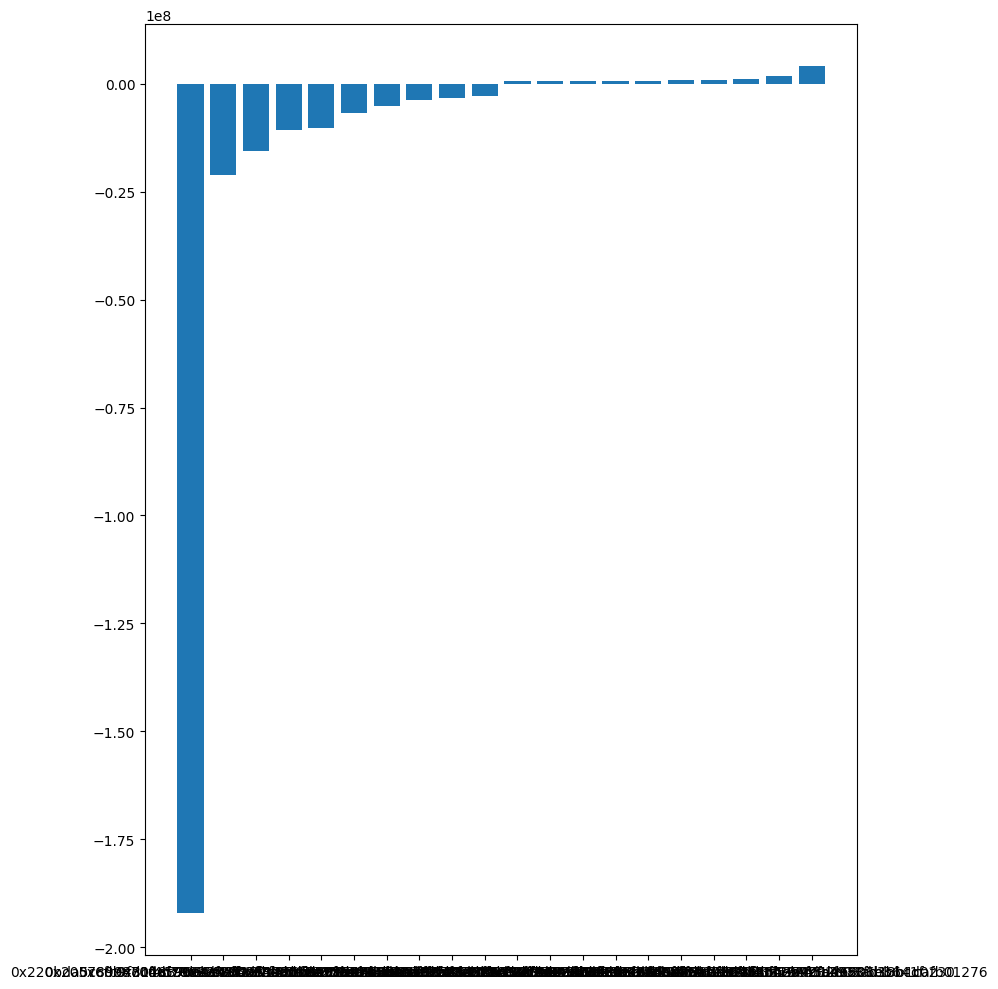

In [143]:
top_performers = ranking_by_sum.head(10).iloc[::-1]
worst_performers = ranking_by_sum.tail(10).iloc[::-1]

performers = pd.concat([worst_performers, top_performers])

f, ax = plt.subplots(figsize=(10, 10))

ax.bar(performers.index, performers[(markout_col, 'sum')])
f.tight_layout()
f.show()

<Axes: xlabel='timestamp'>

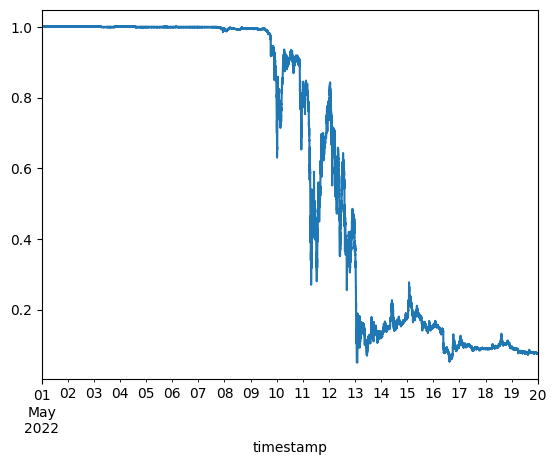

In [87]:
ohlcvs['0xa693b19d2931d498c5b318df961919bb4aee87a5']['close'].plot()

In [5]:
pool_metadata

{'0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7': {'address': '0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7',
  'assetType': 0,
  'baseApr': 0.0,
  'basePool': '0x0000000000000000000000000000000000000000',
  'c128': 0,
  'coins': ['0x6b175474e89094c44da98b954eedeac495271d0f',
   '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
   '0xdac17f958d2ee523a2206206994597c13d831ec7'],
  'creationBlock': 11154878,
  'creationDate': 1604017072,
  'creationTx': '0xd35be3c92c720ae39f99d6e46c9d315b24275f077aa00407b2658e7446be3de3',
  'id': '0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7',
  'isRebasing': 0,
  'isV2': 0,
  'lpToken': '0x6c3f90f043a72fa612cbac8115ee7e52bde6e490',
  'metapool': 0,
  'name': 'Curve.fi DAI/USDC/USDT',
  'poolType': 'REGISTRY_V1',
  'virtualPrice': 1025729876516916855,
  'symbol': '3Crv'},
 '0xdc24316b9ae028f1497c275eb9192a3ea0f67022': {'address': '0xdc24316b9ae028f1497c275eb9192a3ea0f67022',
  'assetType': 1,
  'baseApr': 0.0,
  'basePool': '0x000000000000000000000000000000000000000